# Monte Carlo simulations using Stata
``2020-11-21``  
_Zhiyuan Chen, Department of Trade Economics, Renmin Business School_
* Main Reference: _A. Colin Cameron and Pravin K. Trivedi, Microeconometrics Using Stata, Second Edition, 2010, Chapter 4_

## Overview
Computer simulations are useful to give insight into complicated problems when detailed analytic studies are not possible. Because stochastic simulations intorduce randomness into the study, they are often referred to as __Monte Carlo methods__ after the capital city of the principality of Monaco, which is known for gambling. 
* Econometricians resort to __Monte Carlo studies__ to evaluate the properties of estimators, or compare a proposed estimator to another in a context where analytical derivation of those properties is not feasible. 

* An Monte Carlo simulation of an estimator approximates the sampling distribution of an estimator by simulation methods for a particular data-generating process (DGP) and sample size.

<u>__Goal:__</u>
Our goal is to perform Monte Carlo simulations to study an estimator in Stata. 

## Pseudorandom-number generators in Stata
The random-number generator is the software today is not really random. It is more accurate to use the term pseudorandom numbers. Psuedorandom-number generators use deterministric devices to procuce long chains of numbers that mimic the realizations from some target distributions.  

>A good introduction to the random-number generators in Stata can be found [here](https://blog.stata.com/2016/03/10/how-to-generate-random-numbers-in-stata/).

### Uniform draws

In [1]:
* Single draw of a uniform number
set seed 10101
scalar u = runiform()
disp u




.30422325


In [2]:
* 100 draws of uniform numbers
qui set obs 1000
set seed 10101
g x = runiform()
list x in 1/5, clean






              x  
  1.   .3042232  
  2.   .5540206  
  3.   .2794988  
  4.   .2006274  
  5.   .1246266  


In [3]:
* First 3 autocorrelations for the uniform draws
g t = _n
tsset t
pwcorr x L.x L2.x L3.x, star(0.05)



        time variable:  t, 1 to 1000
                delta:  1 unit


             |        x      L.x     L2.x     L3.x
-------------+------------------------------------
           x |   1.0000 
         L.x |   0.0107   1.0000 
        L2.x |  -0.0004   0.0109   1.0000 
        L3.x |  -0.0210   0.0000   0.0108   1.0000 


### Normal draws

In [4]:
* normal and uniform
clear 
qui set obs 1000
set seed 10101
g uniform = runiform()
g stnormal = rnormal() // N(0,1)
g norm52 = rnormal(5,2)

In [5]:
tabstat uniform stnormal norm52, stat(mean sd skew kurt min max) col(stat)


    variable |      mean        sd  skewness  kurtosis       min       max
-------------+------------------------------------------------------------
     uniform |  .5031233  .2922443 -.0264117  1.809826  .0005628  .9996441
    stnormal |  .0230095  1.023687  -.193405   3.12781 -4.119125  2.615001
      norm52 |  5.090733  1.983719 -.1014361  2.986503 -1.140269  11.52456
--------------------------------------------------------------------------


## The mean of simulated data
We begin by drawing a random sample of size $N$ from a uniform distribution and calculate its mean value.
Recall the central limit theorem states that
$$
\sqrt{N}(\bar{X}-\mu)/\sigma \rightarrow \mathbf{N}(0,1)
$$
We are going to demonstrate this result using simulation.

In [6]:
*Example 1: the mean of simulated data from standard normal distribution
drop _all 
global nobs 500
set obs $nobs
set seed 12345  //make the results reproducible
gen x = runiform() // use rnormal(mu, sigma) for more general cases
sum x




number of observations (_N) was 0, now 500




    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
           x |        500    .4862399    .2909374   .0034476   .9978225


(bin=20, start=.00344757, width=.04971875)


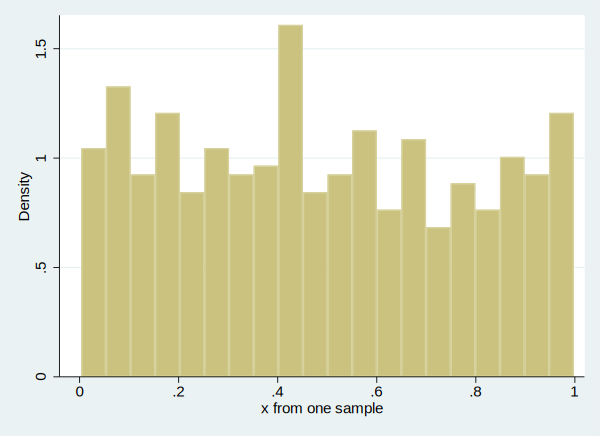

In [7]:
histogram x, bin(20) xtitle("x from one sample")

## The `postfile` command
### Multiple estimates from independently drawn random sample

If we had many estimates, each from an independently drawn random sample, I could estimate the mean and standard deviation of the sampling distribution of the estimator. To this end, we need to repeat the following process:
1. Draw from the DGP (econometric model)
2. Compute the estimate
3. Store the estimate

We can use commands `postfile`, `post`, and `postclose` to store the estimates in memory and write all the stored estimates to a dataset. 

In [8]:
global path "E:\Computation\Resources\Lectures\RMEB\5-MonteCarloSimulation"
qui cd $path

In [9]:
*Example 2: Estimated means of three draws with fixed sample size
set seed 12345
global nobs 500
qui postfile buffer mhat using mcs, replace 
// creates a place in memory called "buffer" in which we store the results
//mhat is the name of the variable
// the dataset is called mcs.dta
//replace so that any previou versions of mcs.dta will be replaced
forvalues i = 1/3 {
    quietly {
      drop _all
      set obs $nobs
      gen y = runiform()
      summ y
    }
    post buffer (r(mean))    // one can also use mean y and _b[y] to store the results
}
postclose buffer

In [10]:
use mcs.dta, clear
list




     +----------+
     |     mhat |
     |----------|
  1. | .4862399 |
  2. | .4988218 |
  3. | .5002428 |
     +----------+


In [11]:
sum mhat


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
        mhat |          3    .4951015    .0077072   .4862399   .5002428


In [12]:
*Example 3: The mean of 2000 estimated means with sample size fixed
set seed 12345
global nobs 500
qui postfile buffer mhat using mcs, replace 
// creates a place in memory called "buffer" in which we store the results
//mhat is the name of the variable
// the dataset is called mcs.dta
//replace so that any previou versions of mcs.dta will be replaced
forvalues i = 1/2000 {
    quietly {
      drop _all
      set obs $nobs
      gen y = runiform()
      sum y
    }
    post buffer (r(mean))    // one can also use mean y and _b[y] to store the results
}
postclose buffer

In [13]:
use mcs.dta,clear
summarize mhat




    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
        mhat |      2,000     .499899    .0128632   .4607484    .543883


The average of 2,000 estimates is close to the true value of the mean of the distribution

(bin=50, start=.4607484, width=.00166269)


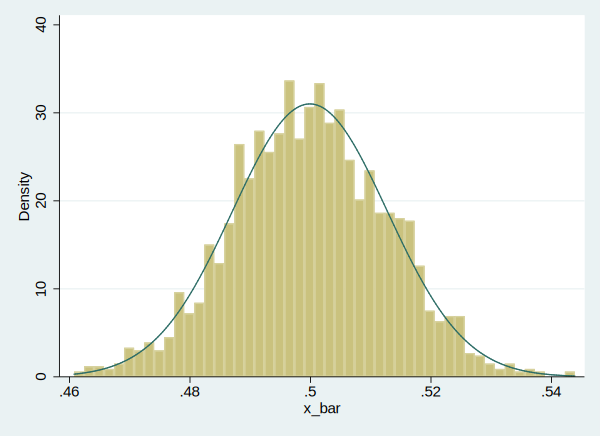

In [14]:
hist mhat, normal bin(50) xtitle("x_bar")

In [15]:
* Example 4: The mean and standard errors
set seed 12345
postfile buffer mhat sehat using mcs, replace
forv i = 1/2000 {
    qui{
        drop _all
        set obs 500
        gen y = rnormal()
        qui sum y
        post buffer (r(mean)) (r(sd))
    }
}
postclose buffer
use mcs.dta,clear
summarize








    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
        mhat |      2,000    .0013082    .0452751  -.1576152   .1466376
       sehat |      2,000    .9988071    .0317767   .8925015   1.099087


### Use MCS to evaluate the asymptotic properties
We want to evaluate the properties of the estimator. We can gradually increase the sample size and look at the performance of the estimator.

In [16]:
* Example 5: The mean and se with increasing sample size 
set seed 12345
postfile buffer n mhat sehat using mcs, replace
forv i = 100(200)10000 {
    qui{
        drop _all
        set obs `i'
        gen y = rnormal()
        qui sum y
        post buffer (r(N)) (r(mean)) (r(sd))
    }
}
postclose buffer
use mcs.dta,clear

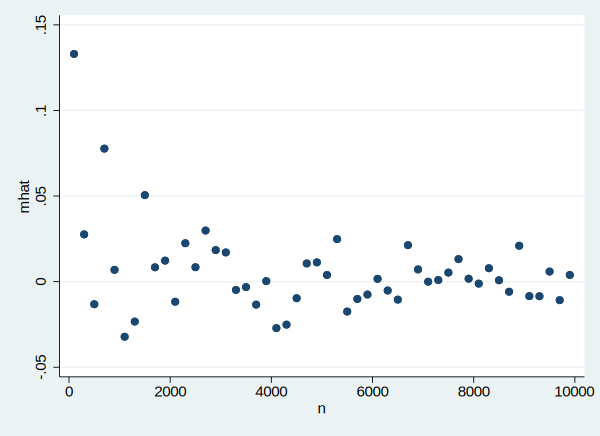

In [17]:
twoway scatter mhat n

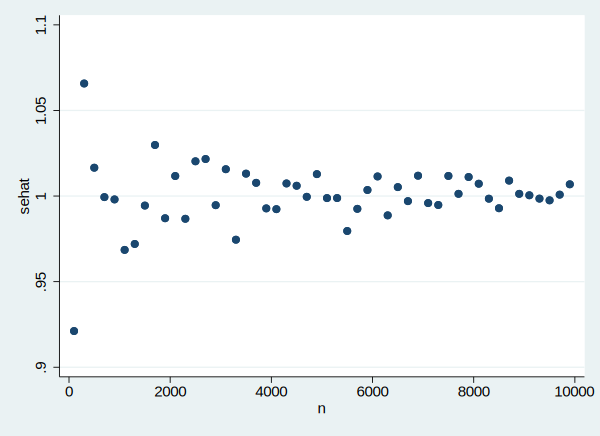

In [18]:
twoway scatter sehat n

## Using `simulate` to perform Monte Carlo simulations
The `simulate` command runds a specified command # times, where the user specifies #.

### Central limit theorem simulation

We first define a program for drawing one sample, then we use `simulate` to exceute the program multiple times

In [19]:
* Program to draw 1 sample of size 30 from uniform and return sample mean
capture program drop onesample
program onesample, rclass
        drop _all
        qui set obs 30
        g x = runiform()
        summ x
        return scalar samplemean = r(mean)
 end

In [20]:
* Run program onesample once to check it
set seed 10101
onesample
return list




    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
           x |         30     .380269    .2706183    .014999    .886691


scalars:
         r(samplemean) =  .3802689793519676




      command:  onesample
         xbar:  r(samplemean)



    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
        xbar |     10,000     .499825    .0521404    .306084   .6868161

(bin=40, start=.30608404, width=.0095183)


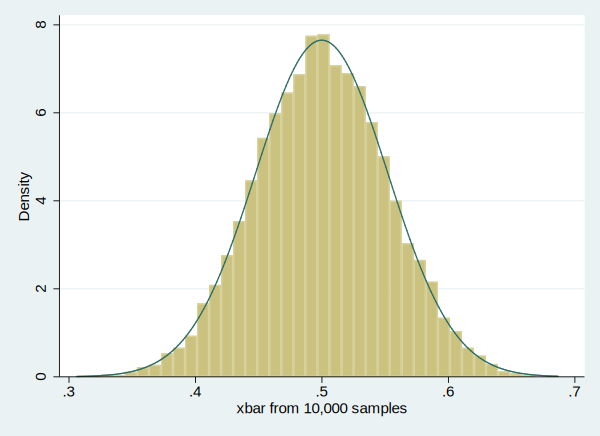

In [21]:
* Run program onesample 10,000 times to get 10,000 sample means
simulate xbar = r(samplemean), seed(10101) reps(10000) nodots: onesample
summ xbar
hist xbar, normal xtitle("xbar from 10,000 samples")

In [33]:
*Loop over simulation times
postfile buffer n xbar using mcsimulate, replace
forv i = 10(10)1000{
    qui simulate xbar = r(samplemean), seed(10101) reps(`i') nodots: onesample
    qui summ xbar
    post buffer (r(N)*30) (r(mean))
}
postclose buffer


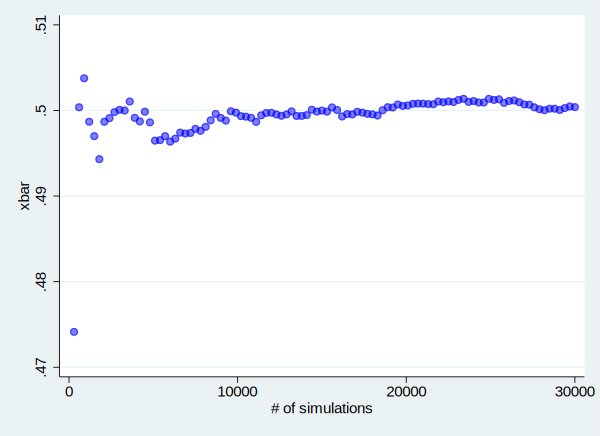

In [38]:
use mcsimulate.dta,clear
twoway scatter xbar n, color(blue%50) xtitle("# of simulations")